In [388]:
from astropy.io import fits
from astropy.wcs import WCS
import png
import numpy as np
from utils import zscale
import matplotlib.pyplot as plt
import math
import scipy
from os import listdir
from os.path import isfile, join
import cupy as cp
from natsort import os_sorted #NEEDED FOR LINUX

DATA_PATH = 'SatSimFITS'
TOTAL_VELOCITY_VECTORS = 1000
IMAGES_TO_STACK = os_sorted([DATA_PATH + '/' + f for f in listdir(DATA_PATH) if isfile(join(DATA_PATH, f))])
NUM_FRAMES = len(IMAGES_TO_STACK)
DIMENSIONS = (512, 512)

Images before preprocessing

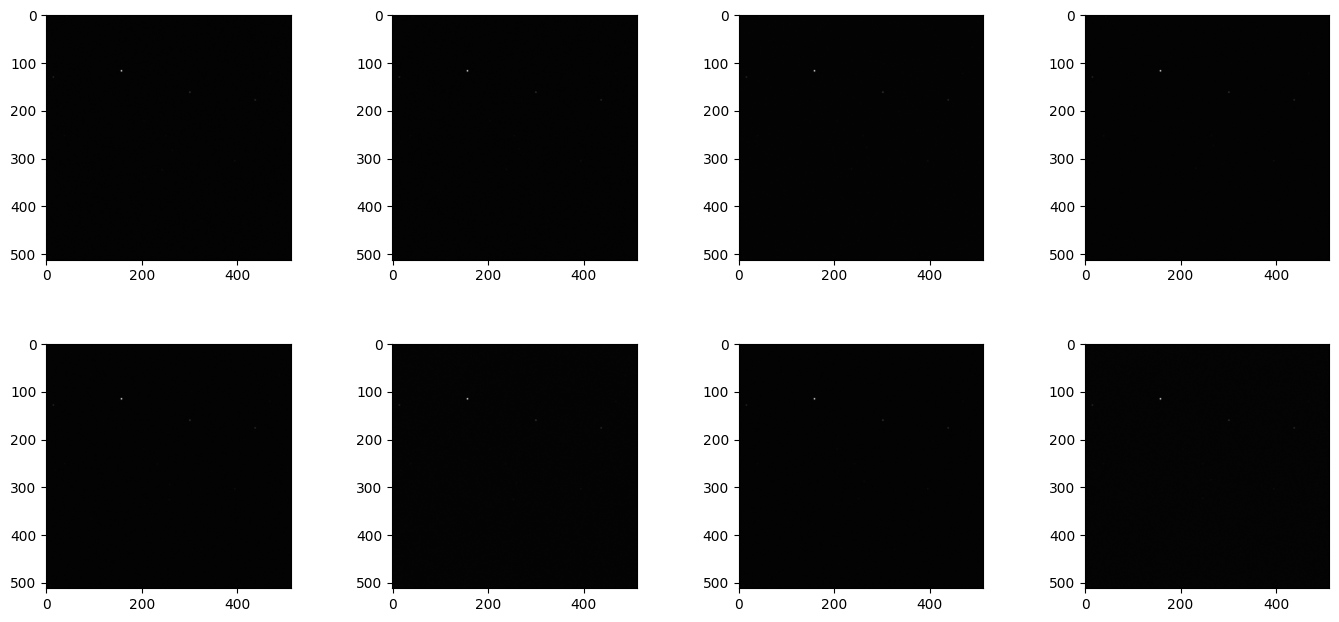

In [434]:
plt.rcParams["figure.figsize"] = [14.00, 16.00]
plt.rcParams["figure.autolayout"] = True

total_images = len(IMAGES_TO_STACK)
row_counter = 1
column_counter = 1
for file in IMAGES_TO_STACK:
    plt.subplot(row_counter, 4, column_counter)
    plt.imshow((fits.open(file)[0].data), cmap="Greys_r")
    column_counter += 1
    if column_counter > 4:
        column_counter = 1
        row_counter += 1

Star Field Correction.
Finds the background, and removes stars based on the first frame in the folder. Then applies the star removal to all other frames.

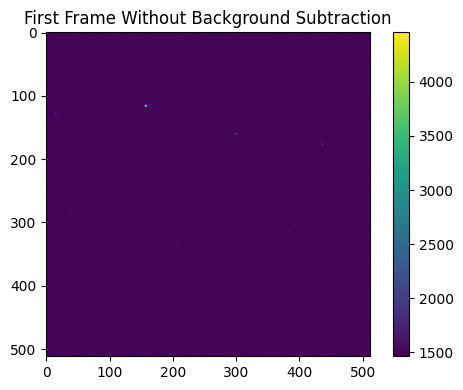

In [390]:
first_frame = fits.open(IMAGES_TO_STACK[0])[0].data

plt.rcParams["figure.figsize"] = [5, 4]
plt.imshow(first_frame,
           interpolation='nearest')
plt.title('First Frame Without Background Subtraction')
plt.colorbar()

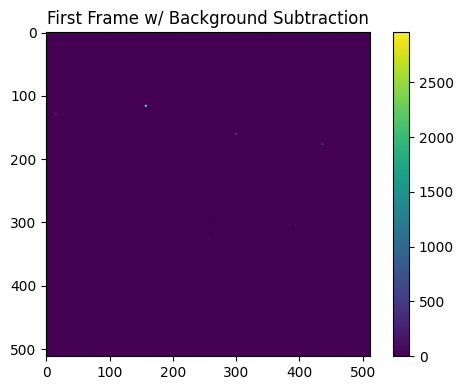

In [391]:
import numpy as np
from photutils.datasets import make_test_psf_data, make_noise_image
from photutils.psf import IntegratedGaussianPRF
import matplotlib.pyplot as plt
import png
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground

first_frame = fits.open(IMAGES_TO_STACK[0])[0].data

#Code to find the background
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
bkg = Background2D(first_frame, (50, 50), filter_size=(3, 3),
                   sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
new_img = (first_frame - bkg.background).clip(min=0)


plt.rcParams["figure.figsize"] = [5, 4]
plt.imshow(new_img,
           interpolation='nearest')
plt.title('First Frame w/ Background Subtraction')
plt.colorbar()

In [392]:
from cupyx.scipy import ndimage

def stack(frames: list, velocity_vector):
    '''
    Inputs:
        file_path is a list of strings refering to the images that are to be stacked
        
        velocity_vector is a 2D numpy array where the first entry is the x velocity 
        and the second is the y velocity. (i.e [-1, 2]). As of now, the units of vel
        are pixel/frame.

    Output:
        a stacked image of all frames.
    '''
    final_dimensions = DIMENSIONS
    stacked_image = cp.zeros(shape=final_dimensions)
    iter = 0
    init_x_vel = velocity_vector[0]
    init_y_vel = velocity_vector[1]

    for image in frames:
        img_shifted = ndimage.shift(image, velocity_vector, mode='constant')
        if iter != 0:
            stacked_image += img_shifted
        iter += 1
        velocity_vector = [init_y_vel * iter, init_x_vel * iter]
    return stacked_image

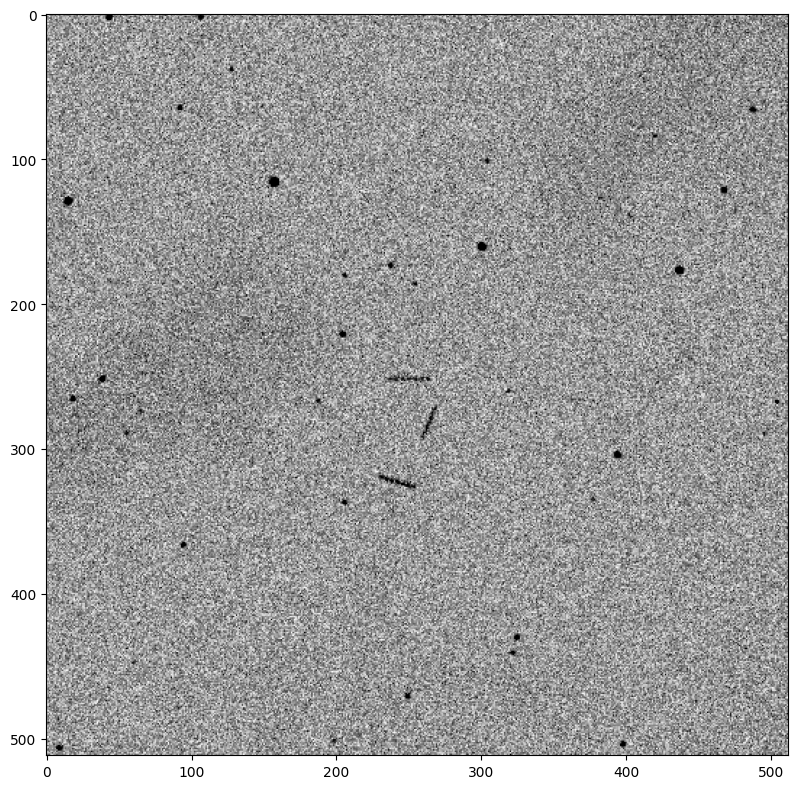

In [450]:
star_detect = []
for file in IMAGES_TO_STACK:
    unprocessed_img = fits.open(file)[0].data
    no_bkg = (unprocessed_img - bkg.background)
    star_detect.append(cp.asarray(no_bkg))

img_for_star_detect = stack(star_detect, cp.asarray([0, 0]))
new_img = cp.ndarray.get(img_for_star_detect)
plt.rcParams["figure.figsize"] = [10, 8]
plt.imshow(zscale(new_img),cmap='Greys')

In [452]:
from photutils.detection import DAOStarFinder
from photutils.psf import PSFPhotometry

#Code for PSF and star removal
psf_model = IntegratedGaussianPRF(flux=1, sigma=2.7 / 2.35)
fit_shape = (11, 11)
finder = DAOStarFinder(100.0, 5)
psfphot = PSFPhotometry(psf_model, fit_shape, finder=finder,
                        aperture_radius=4)
phot = psfphot(new_img)

#To look at removed stars
phot['x_fit'].info.format = '.4f' 
phot['y_fit'].info.format = '.4f'
phot['flux_fit'].info.format = '.4f'
print(phot[('id', 'x_fit', 'y_fit')]) 

'''
resid = psfphot.make_residual_image(new_img, (9, 9))
print(resid.shape)
resid = resid.clip(min = 0)

plt.rcParams["figure.figsize"] = [10, 8]
plt.imshow(resid, cmap = 'Greys_r')
plt.title('Removed Stars Without Catalog Matching')
plt.colorbar()
'''

 id  x_fit    y_fit  
--- -------- --------
  1 106.2399   2.1863
  2  43.0437   2.4636
  3 127.4866  38.3961
  4  91.9351  64.6838
  5 487.4341  66.1201
  6 419.5217  84.2855
  7 157.2319 116.1058
  8 467.3286 121.4717
  9  14.9029 129.0992
 10 156.4303 141.5081
...      ...      ...
 28 231.3277 319.7475
 29 238.1140 322.1010
 30 376.9719 334.9094
 31 205.5338 337.1494
 32  94.3390 366.3941
 33 324.4494 430.1549
 34 321.8013 440.9614
 35 248.9466 470.7816
 36 198.4082 501.6467
 37 397.6796 503.9358
 38   8.8270 506.4076
Length = 38 rows


'\nresid = psfphot.make_residual_image(new_img, (9, 9))\nprint(resid.shape)\nresid = resid.clip(min = 0)\n\nplt.rcParams["figure.figsize"] = [10, 8]\nplt.imshow(resid, cmap = \'Greys_r\')\nplt.title(\'Removed Stars Without Catalog Matching\')\nplt.colorbar()\n'

In [396]:
import astrometry

solver = astrometry.Solver(
    astrometry.series_5200.index_files(
        cache_directory= 'astrometry_cache/portal.nersc.gov/project/cosmo/temp/dstn/index-5200/LITE',
        scales = {0, 1, 2, 3, 4, 5, 6},
    )
)

In [397]:
stars = np.asarray([[x, y] for x, y in zip(phot['x_fit'], phot['y_fit'])])
print(stars)


[[106.23986315   2.18632357]
 [ 43.04369433   2.46364465]
 [127.48656929  38.39605112]
 [ 91.9350558   64.68376975]
 [487.43409408  66.12005467]
 [419.52165371  84.28551223]
 [157.23192276 116.10577048]
 [467.32856137 121.47172942]
 [ 14.90291091 129.09923518]
 [156.43027303 141.50807264]
 [300.23625293 160.69695777]
 [237.20003714 173.67534859]
 [436.58509413 176.9022502 ]
 [205.71676116 180.50734567]
 [254.09724178 186.24601368]
 [204.18291597 221.08003623]
 [ 38.39742322 251.79689268]
 [254.68672515 252.03568745]
 [263.23547888 251.85293351]
 [318.79547291 260.31794779]
 [ 18.20658422 265.41206329]
 [187.45674032 267.00369597]
 [504.0587947  267.66351558]
 [267.62460196 273.02304093]
 [ 55.20800119 289.26646712]
 [495.40911816 289.5137276 ]
 [394.00461562 304.23144386]
 [231.3277388  319.74749685]
 [238.11403784 322.10095922]
 [376.97194768 334.9093859 ]
 [205.5338417  337.14939618]
 [ 94.33896213 366.39412984]
 [324.44944227 430.15486923]
 [321.80126147 440.9613992 ]
 [248.94656959

In [398]:
solution = solver.solve(
    stars=stars,
    size_hint=None,
    position_hint=None,
    solution_parameters=astrometry.SolutionParameters(),
)

In [399]:
if solution.has_match():
    for star in solution.best_match().stars:
        print(f"{star.ra_deg}º, {star.dec_deg}º:", star.metadata)
    

81.20461975323259º, -18.772685057477236º: {}
81.33768848237615º, -18.758734388277563º: {}
81.43730065342842º, -18.58876757494901º: {}
81.53777872059506º, -18.840459934108928º: {}
81.46796615494033º, -18.73994794219162º: {}
81.47335232214155º, -18.82642536687014º: {}
81.44653323565687º, -18.87144665459737º: {}
81.44525403814407º, -18.62332732845602º: {}
81.32790887478802º, -18.868039815845982º: {}
81.25261373017324º, -18.841050561673153º: {}
81.17681102674607º, -18.699089465066848º: {}
81.37769269412924º, -18.817424288174315º: {}
81.33927126939508º, -18.72407214322894º: {}
81.35055316802014º, -18.665659819722173º: {}
81.43001876658657º, -18.90353847844377º: {}
81.21069434166893º, -18.678703735083896º: {}
81.47567760411042º, -18.83268707875109º: {}
81.4067234538071º, -18.619850321434747º: {}
81.41259932936042º, -18.74185037611913º: {}
81.22422106516785º, -18.71515712154977º: {}
81.34425251630861º, -18.78741523709848º: {}
81.46909604680748º, -18.76100818819191º: {}
81.32478458421271º, -18

In [400]:
if solution.has_match():
    wcs = solution.best_match().astropy_wcs()
    pixels = wcs.all_world2pix(
        [[star.ra_deg, star.dec_deg] for star in solution.best_match().stars],
        0,
    )
print(pixels)

[[ 13.86026039 128.12184336]
 [203.19549505 220.12972042]
 [486.4976824   65.22104483]
 [396.61055051 502.95879238]
 [393.05640203 303.30717087]
 [323.4854703  429.18331953]
 [247.87023844 469.69076339]
 [466.3570821  120.38747661]
 [ 93.33073534 365.39796438]
 [ 17.24117901 264.44859593]
 [ 42.04034148   1.4496174 ]
 [204.3215257  336.15356645]
 [236.08514444 172.78912997]
 [303.0356628  100.30290171]
 [197.43733372 500.71054557]
 [105.2729112    1.21819135]
 [321.01626729 439.91066418]
 [418.38347979  83.20906109]
 [317.809458   259.41918139]
 [ 90.88789376  63.68578285]
 [186.47634048 265.92420651]
 [375.87846768 333.83515286]
 [204.84667183 179.52103237]
 [156.2550355  114.99903044]
 [299.34736916 159.67890907]
 [ 37.43395144 250.74199283]
 [435.54940085 175.87819193]]


In [401]:
import astroalign as aa

transf, (s_list, t_list) = aa.find_transform(stars, pixels)

print(s_list)

[[ 94.33896213 366.39412984]
 [ 14.90291091 129.09923518]
 [ 91.9350558   64.68376975]
 [318.79547291 260.31794779]
 [198.40822884 501.64674778]
 [467.32856137 121.47172942]
 [300.23625293 160.69695777]
 [248.94656959 470.78162284]
 [487.43409408  66.12005467]
 [157.23192276 116.10577048]
 [ 38.39742322 251.79689268]
 [397.67955445 503.93581259]
 [205.5338417  337.14939618]
 [324.44944227 430.15486923]
 [321.80126147 440.9613992 ]
 [394.00461562 304.23144386]
 [204.18291597 221.08003623]
 [205.71676116 180.50734567]
 [ 18.20658422 265.41206329]
 [376.97194768 334.9093859 ]
 [187.45674032 267.00369597]
 [436.58509413 176.9022502 ]
 [419.52165371  84.28551223]
 [237.20003714 173.67534859]
 [106.23986315   2.18632357]
 [ 43.04369433   2.46364465]]


(512, 512)


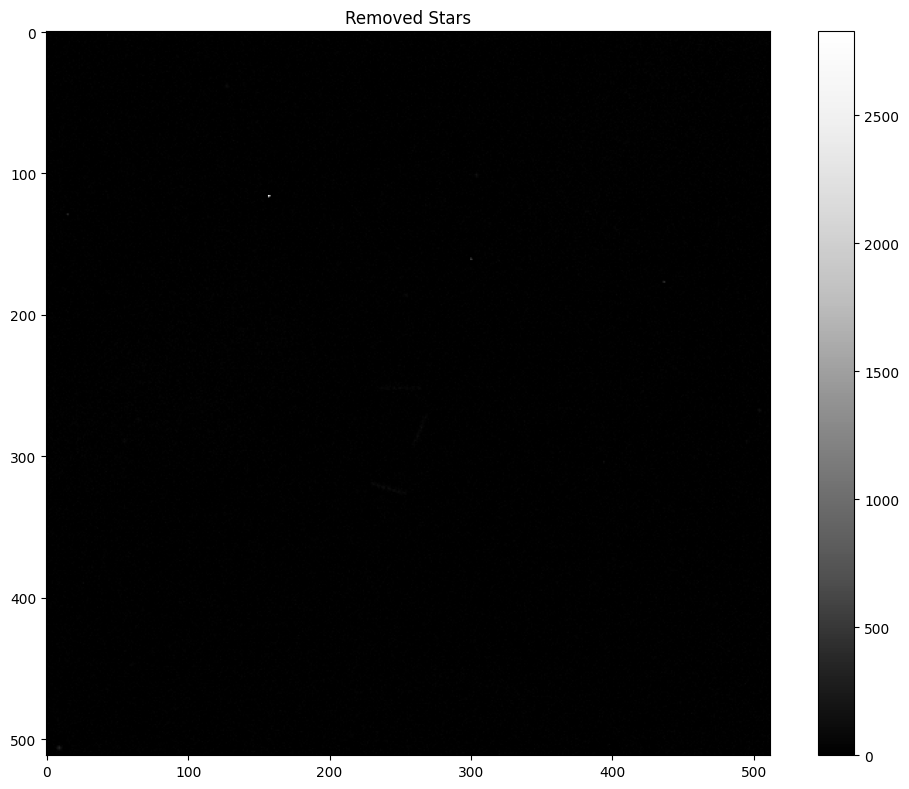

In [402]:
from astropy.table import QTable
init_params = QTable()
init_params['x'] = s_list[:,0] 
init_params['y'] = s_list[:,1] 
phot = psfphot(new_img, init_params = init_params)

resid = psfphot.make_residual_image(new_img, (9, 9))
print(resid.shape)
resid = resid.clip(min = 0)

plt.rcParams["figure.figsize"] = [10, 8]
plt.imshow(resid, cmap = 'Greys_r')
plt.title('Removed Stars')
plt.colorbar()


In [403]:
processed_images = []
for file in IMAGES_TO_STACK:
    unprocessed_img = fits.open(file)[0].data
    no_bkg = (unprocessed_img - bkg.background)
    processed_images.append(psfphot.make_residual_image(no_bkg, (9, 9)).clip(min=0))

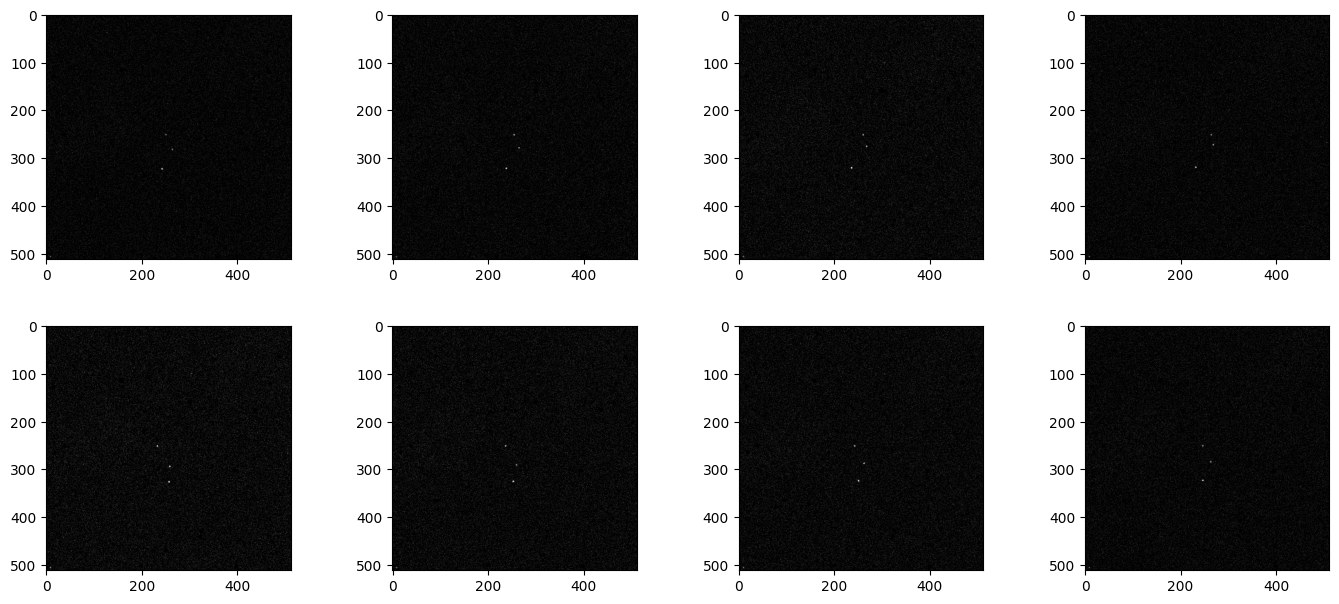

In [404]:
plt.rcParams["figure.figsize"] = [14.00, 15.00]
plt.rcParams["figure.autolayout"] = True

total_images = len(IMAGES_TO_STACK)
row_counter = 1
column_counter = 1
for image in processed_images:
    plt.subplot(row_counter, 4, column_counter)
    plt.imshow(image, cmap= 'Greys_r')
    column_counter += 1
    if column_counter > 4:
        column_counter = 1
        row_counter += 1

In [405]:
#Convert to cupy arrays
processed_images_cupy = []
for image in processed_images:
    processed_images_cupy.append(cp.asarray(image))

Creates the predictive velocity vectors in which shifts will be applied

In [406]:
#For rounding
a = int(math.sqrt(TOTAL_VELOCITY_VECTORS)) 
b = math.floor(a/2)
if a % 2 == 0:
    a += 1

velocities = cp.zeros(shape = (a * a, 2))
vel_to_idx = {}

idx = 0
for i in range(-b, b+1):
    for j in range(-b, b+1):
        vel_to_idx[(i,j)] = idx
        velocities[idx] = cp.asarray([i,j])
        idx += 1

print('A total of ' + str(a * a) + ' velocities will be tested.')
print('Range of velocity for both x and y direction: ' + str([-b, b]))

A total of 961 velocities will be tested.
Range of velocity for both x and y direction: [-15, 15]


In [408]:
from cupyx.scipy import ndimage

def stack(frames: list, velocity_vector):
    '''
    Inputs:
        file_path is a list of strings refering to the images that are to be stacked
        
        velocity_vector is a 2D numpy array where the first entry is the x velocity 
        and the second is the y velocity. (i.e [-1, 2]). As of now, the units of vel
        are pixel/frame.

    Output:
        a stacked image of all frames.
    '''
    final_dimensions = DIMENSIONS
    stacked_image = cp.zeros(shape=final_dimensions)
    iter = 0
    init_x_vel = velocity_vector[0]
    init_y_vel = velocity_vector[1]

    for image in frames:
        img_shifted = ndimage.shift(image, velocity_vector, mode='constant')
        if iter != 0:
            stacked_image += img_shifted
        iter += 1
        velocity_vector = [init_y_vel * iter, init_x_vel * iter]
    return stacked_image

Example usage of the stack function with velocity vector [0, -3]

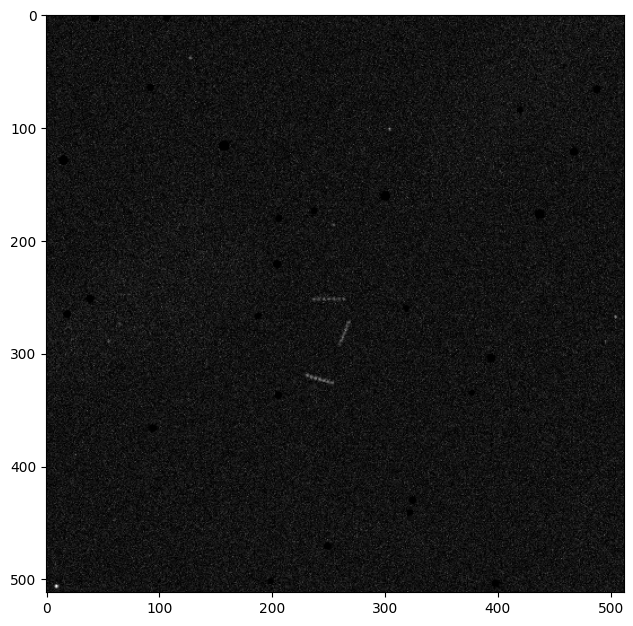

In [409]:
plt.rcParams["figure.figsize"] = [7.5, 7.5]
plt.rcParams["figure.autolayout"] = False
final = stack(processed_images_cupy, [0, 0])
plt.imshow((cp.ndarray.get(final)), cmap="Greys_r")

In [410]:
def build_data_cube(images, all_vectors):
    '''
    Creates a dictionary of stacked frames for each velocity vector

    Inputs: file_path is a list of strings refering to the images that are to be stacked

    all_vectors is a list of 2D numpy array where the first entry is the x velocity 
        and the second is the y velocity. (i.e [-1, 2]). As of now, the units of vel
        are pixel/frame.
    
    Output: a dictionary of the final stacked frames where the velocity vector in tuple 
        form is the key for retreiving a stacked image.
    '''
    data_cube = []
    for velocity in all_vectors:
        stacked_image = stack(images, velocity_vector=velocity)
        data_cube.append(stacked_image)
    return data_cube

data_cube = build_data_cube(processed_images_cupy, velocities)

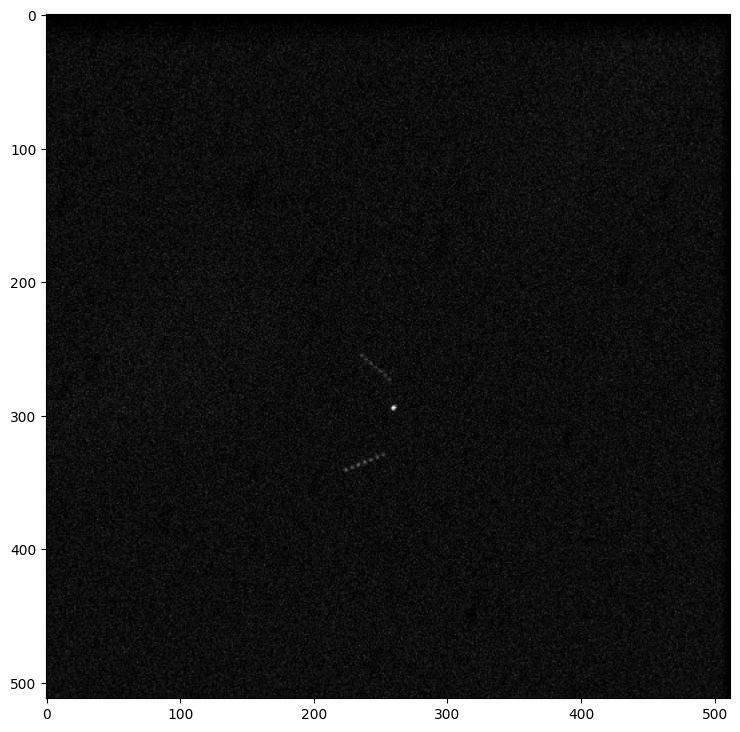

In [498]:
plt.rcParams["figure.figsize"] = [7.5, 7.5]
plt.imshow((cp.ndarray.get(data_cube[vel_to_idx[(-1, 3)]])), cmap="Greys_r")

In [412]:
print(cp.ndarray.get(data_cube[vel_to_idx[(1,3)]]))

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 1.87362207e-02 2.13892022e-15 ... 2.12992355e+01
  6.06313855e+01 3.53108181e+01]
 [0.00000000e+00 3.44142459e-16 1.00198191e+01 ... 1.49775576e+01
  1.73150246e+01 2.69867562e+01]
 [0.00000000e+00 1.00208437e+01 2.00385590e+01 ... 3.09849891e+01
  3.73090857e+01 2.66613665e+01]]


In [453]:
heatmap = cp.zeros(shape=(b * 2 + 1, b * 2 + 1))

idx = 0
for i in range(b * 2 + 1):
    for j in range(b * 2 + 1):
        heatmap[i][j] = cp.amax(data_cube[vel_to_idx[(-b + j, b - i)]])
        velocities[idx] = cp.asarray([i,j])
        idx += 1

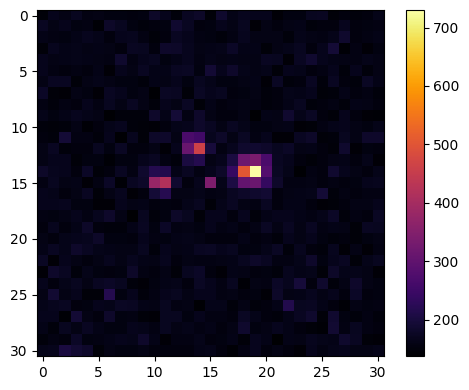

In [459]:
plt.rcParams["figure.figsize"] = [5, 4]
plt.imshow((cp.ndarray.get(heatmap)), cmap = 'inferno')
plt.colorbar()

/tmp/ipykernel_738/3567909745.py:1: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import maximum_filter
/tmp/ipykernel_738/3567909745.py:2: DeprecationWarning: Please use `generate_binary_structure` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
/tmp/ipykernel_738/3567909745.py:2: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import generate_binary_structure, binary_erosion


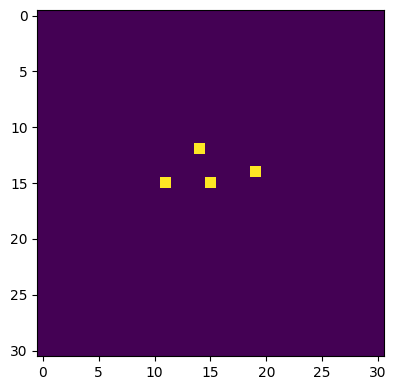

In [464]:
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion

def detect_peaks(image):
    """
    Takes an image and detect the peaks using the local maximum filter.
    Returns a boolean mask of the peaks (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """
    neighborhood = generate_binary_structure(2,2)
    local_max = maximum_filter(image, footprint=neighborhood)==image
    #Mask of the background
    background = (image==0)
    #Padding for background that gets removed by the maximum_filter
    eroded_background = binary_erosion(background, structure=neighborhood, border_value=1) 
    #Remove background
    detected_peaks = local_max ^ eroded_background

    return detected_peaks


#applying the detection and plotting results

detected_peaks = detect_peaks((cp.ndarray.get(heatmap) - 250).clip(min=0))
plt.imshow(detected_peaks)

In [524]:
detection_velocities =( np.transpose((detected_peaks).nonzero()) - b ) 

formatted_velocities = np.asarray([np.asarray([x, -y]) for y, x in detection_velocities])
print(formatted_velocities)


[[-1  3]
 [ 4  1]
 [-4  0]
 [ 0  0]]


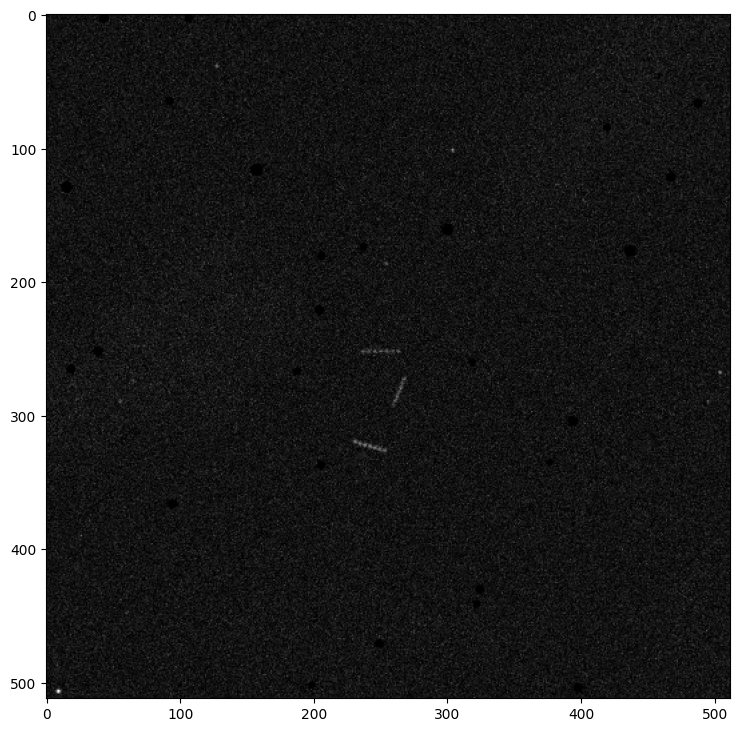

In [507]:
plt.rcParams["figure.figsize"] = [7.5, 7.5]
plt.imshow((cp.ndarray.get(data_cube[vel_to_idx[(0,0)]])), cmap="Greys_r")

In [553]:
fits_wcs = fits.open(IMAGES_TO_STACK[0])
image_wcs = WCS(fits_wcs[0])

for det_vel in formatted_velocities:
    stacked = stack(processed_images_cupy, det_vel)
    index = (cp.unravel_index(cp.argmax(stacked, axis = None), stacked.shape))
    x = cp.ndarray.get(index[1])
    y = cp.ndarray.get(index[0])
    start_radec = image_wcs.pixel_to_world(x, y)
    end_radec = image_wcs.pixel_to_world((x + det_vel[0]), (y + det_vel[1]))
    print("Detected object at moving at velocity <" + str((start_radec.ra.deg - end_radec.ra.deg)/1.6) + ' ' +  str((start_radec.dec.deg - end_radec.dec.deg)/1.6)+ "in RA, Dec degrees/second.")

Detected object at moving at velocity <0.6211530349151597-1.2720038401930456in RA, Dec degrees/second.
Detected object at moving at velocity <-2.4801360961585983-0.1352169018888194in RA, Dec degrees/second.
Detected object at moving at velocity <2.152716412359119-0.041847204491903545in RA, Dec degrees/second.
Detected object at moving at velocity <0.00.0in RA, Dec degrees/second.
